In [1]:
"""
The paper conclude that the larger the snippet size, the more time required to read, and the worse the user satisfation

This script is to test that if the model on average give a lower satisfaction score larger snippet size

Columns Used (one of the top 10 feature subset)
Index(['Snippet_length', 'Shown_T_num', 'Log(TTF)', 'StartTime',
       'Endtime_SERP', 'Log(F_title)', 'Log(F_URL)', 'Log(F_Snippet)'],
      dtype='object')
Chromosome: 111000111110000

Hyperparameter Used (the best hyperparameter combination)
Hyperpararmeters Used: {'max_hidden_neurons': 1, 'P': 0.5, 'D': 0, 'lrs': [0.1, 0.0025, 0.0005]}

"""

import numpy as np
import torch
from utilities import import_data
from features_grid_search import chromosome_to_dataset
from sklearn.model_selection import train_test_split
from casper_test import final_test
from utilities import set_seed
from casper import train
from casper import CasperNet
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


SEED = None
if SEED != None:
    set_seed(SEED)

DEVICE = 'cpu'

HYPERPARAMETERS = {'max_hidden_neurons': 1, 'P': 0.5, 'D': 0, 'lrs': [0.1, 0.0025, 0.0005]}
DATA_SUBSET_CHROMOSOME = '111000111110000'

data_origin, _, _ = import_data()

DATA = chromosome_to_dataset(DATA_SUBSET_CHROMOSOME, data_origin)
NUM_OF_FEATURES = DATA.shape[1] - 1


def output_to_satisfaction_score(output):
    """
    convert the output of the model into satisfaciton score
    """
    output = np.round(output)
    if output > 7:
        output = 7
    if output < 1:
        output = 1
    return output

def decode_snippet_length(encode):
    """
    decode snippet length
    """
    if encode < -1.1:
        return 'long'
    elif encode < 0:
        return 'median'
    else:
        return 'short'

output_to_satisfaction_score = np.vectorize(output_to_satisfaction_score)
decode_snippet_length = np.vectorize(decode_snippet_length)

NUM_OF_TESTS = 2000

Hyperpararmeters Used: {'max_hidden_neurons': 1, 'P': 0.5, 'D': 0, 'lrs': [0.1, 0.0025, 0.0005]}


In [2]:
predicted_scores_for_short_snippets = []
predicted_scores_for_median_snippets = []
predicted_scores_for_long_snippets = []

scores_for_short_snippets = []
scores_for_median_snippets = []
scores_for_long_snippets = []

for i in range(NUM_OF_TESTS):
    train_data, test_data, _, _ = train_test_split(DATA, DATA.iloc[:,0], test_size=0.2, random_state=SEED)
    train_data, test_data = np.array(train_data), np.array(test_data)

    # initialise network
    casper_net = CasperNet(NUM_OF_FEATURES, 1).to(DEVICE)

    # train the model
    train(casper_net, train_data, HYPERPARAMETERS, task='regression', verbose=False)

    casper_net.eval()

    # calculate score for sample in the test set
    inputs = torch.Tensor(test_data[:, 1:]).float().to(DEVICE)
    with torch.no_grad():
        outputs = casper_net(inputs)
        utputs = outputs.cpu().numpy()
    
    true_scores = test_data[:, 0]
    satisfaction_scores = output_to_satisfaction_score(outputs)
    snippet_lengths = decode_snippet_length(test_data[:, 1])

    if (i + 1) % 20 == 0:
        print(f'Test {i + 1}/{NUM_OF_TESTS}', end='\r')
print()

# put into different list according to their snippet length
for i in range(len(outputs)):
    if snippet_lengths[i] == 'long':
        predicted_scores_for_long_snippets.append(satisfaction_scores[i])
        scores_for_long_snippets.append(true_scores[i])
    elif snippet_lengths[i] == 'median':
        predicted_scores_for_median_snippets.append(satisfaction_scores[i])
        scores_for_median_snippets.append(true_scores[i])
    else:
        predicted_scores_for_short_snippets.append(satisfaction_scores[i])
        scores_for_short_snippets.append(true_scores[i])

Test 2000/2000


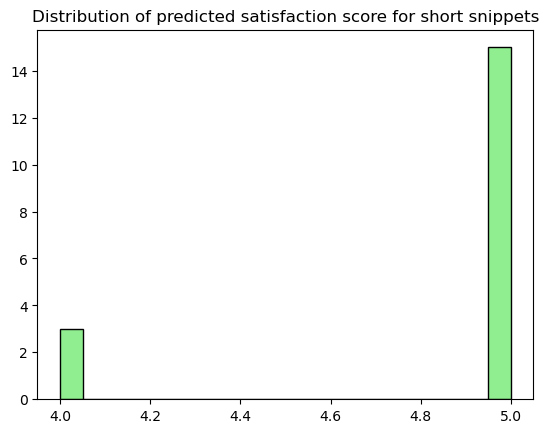

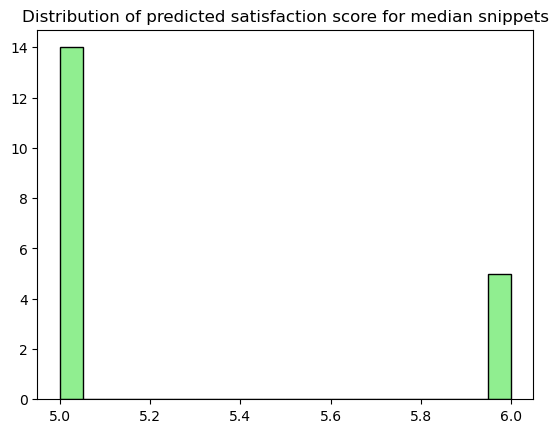

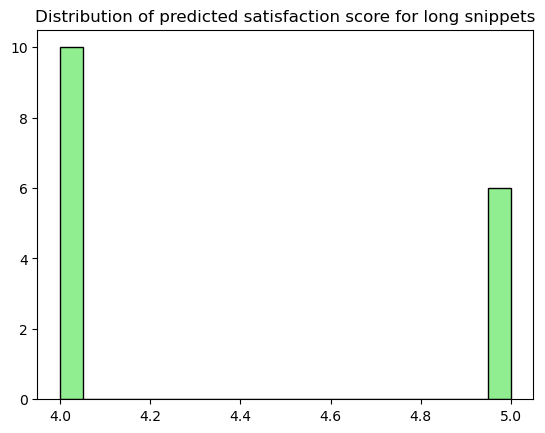

Predicted scores for short snippet
Mean: 4.833333492279053
Median: 5.0
Standard Deviation: 0.3726780116558075

Predicted scores for median snippet
Mean: 5.263157844543457
Median: 5.0
Standard Deviation: 0.4403473734855652

Predicted scores for long snippet
Mean: 4.375
Median: 4.0
Standard Deviation: 0.4841229319572449


In [3]:
plt.title("Distribution of predicted satisfaction score for short snippets")
plt.hist(predicted_scores_for_short_snippets, color='lightgreen', ec='black', bins=20)
plt.show()
plt.title("Distribution of predicted satisfaction score for median snippets")
plt.hist(predicted_scores_for_median_snippets, color='lightgreen', ec='black', bins=20)
plt.show()
plt.title("Distribution of predicted satisfaction score for long snippets")
plt.hist(predicted_scores_for_long_snippets, color='lightgreen', ec='black', bins=20)
plt.show()

print("Predicted scores for short snippet")
print(f'Mean: {np.mean(predicted_scores_for_short_snippets)}')
print(f'Median: {np.median(predicted_scores_for_short_snippets)}')
print(f'Standard Deviation: {np.std(predicted_scores_for_short_snippets)}')
print()
print("Predicted scores for median snippet")
print(f'Mean: {np.mean(predicted_scores_for_median_snippets)}')
print(f'Median: {np.median(predicted_scores_for_median_snippets)}')
print(f'Standard Deviation: {np.std(predicted_scores_for_median_snippets)}')
print()
print("Predicted scores for long snippet")
print(f'Mean: {np.mean(predicted_scores_for_long_snippets)}')
print(f'Median: {np.median(predicted_scores_for_long_snippets)}')
print(f'Standard Deviation: {np.std(predicted_scores_for_long_snippets)}')

In [4]:
# P test for the predicted scores between short and median snippet
t_statistic, p_value = ttest_ind(predicted_scores_for_short_snippets, predicted_scores_for_median_snippets)
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: -3.108816545739914
P-value: 0.003719924289234173


In [5]:
# P test for the predicted scores between median and long snippet
t_statistic, p_value = ttest_ind(predicted_scores_for_long_snippets, predicted_scores_for_median_snippets)
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: -5.514834308708879
P-value: 4.035010448338778e-06


In [6]:
# P test for the predicted scores between short and long snippet
t_statistic, p_value = ttest_ind(predicted_scores_for_short_snippets, predicted_scores_for_long_snippets)
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: 3.0183761164669725
P-value: 0.004956345161919292


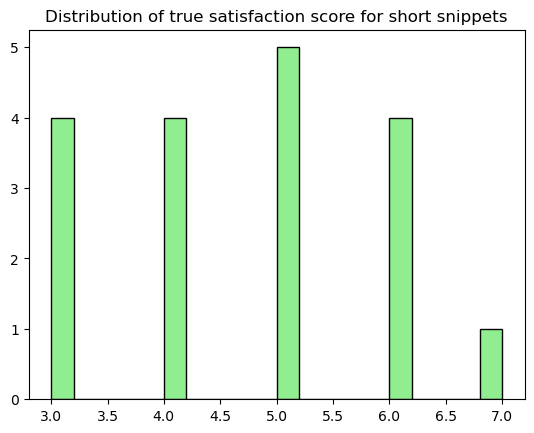

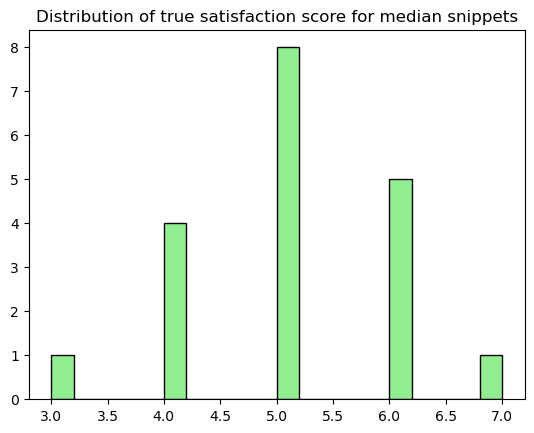

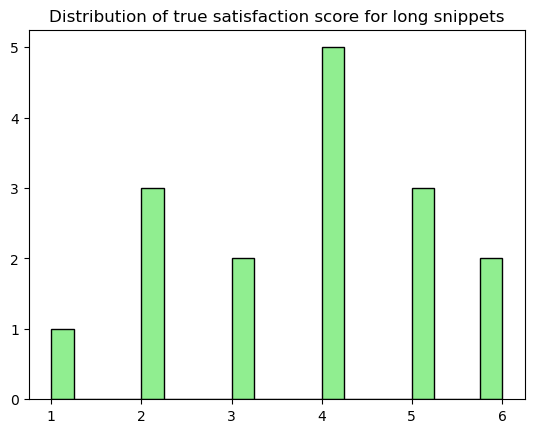

True scores for short snippet
Mean: 4.666666666666667
Median: 5.0
Standard Deviation: 1.2018504251546631

True scores for median snippet
Mean: 5.052631578947368
Median: 5.0
Standard Deviation: 0.944439918154019

True scores for long snippet
Mean: 3.75
Median: 4.0
Standard Deviation: 1.4361406616345072


In [7]:
plt.title("Distribution of true satisfaction score for short snippets")
plt.hist(scores_for_short_snippets, color='lightgreen', ec='black', bins=20)
plt.show()
plt.title("Distribution of true satisfaction score for median snippets")
plt.hist(scores_for_median_snippets, color='lightgreen', ec='black', bins=20)
plt.show()
plt.title("Distribution of true satisfaction score for long snippets")
plt.hist(scores_for_long_snippets, color='lightgreen', ec='black', bins=20)
plt.show()

print("True scores for short snippet")
print(f'Mean: {np.mean(scores_for_short_snippets)}')
print(f'Median: {np.median(scores_for_short_snippets)}')
print(f'Standard Deviation: {np.std(scores_for_short_snippets)}')
print()
print("True scores for median snippet")
print(f'Mean: {np.mean(scores_for_median_snippets)}')
print(f'Median: {np.median(scores_for_median_snippets)}')
print(f'Standard Deviation: {np.std(scores_for_median_snippets)}')
print()
print("True scores for long snippet")
print(f'Mean: {np.mean(scores_for_long_snippets)}')
print(f'Median: {np.median(scores_for_long_snippets)}')
print(f'Standard Deviation: {np.std(scores_for_long_snippets)}')

In [8]:
# P test for the predicted scores between short and median snippet
t_statistic, p_value = ttest_ind(scores_for_short_snippets, scores_for_median_snippets)
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: -1.0593165548258134
P-value: 0.29671178288202954


In [9]:
# P test for the predicted scores between median and long snippet
t_statistic, p_value = ttest_ind(scores_for_long_snippets, scores_for_median_snippets)
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: -3.1205061019134184
P-value: 0.0037371339158137552


In [10]:
# P test for the predicted scores between short and long snippet
t_statistic, p_value = ttest_ind(scores_for_short_snippets, scores_for_long_snippets)
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: 1.9647948350320694
P-value: 0.0581707068803339


Model is trained 2000 times
with each run has different test-training split and initialised weights
Mean: 1.946857632458211.5786    MAE: 1.0255
Median: 1.901840090751648
Standard Deviation: 0.4853510884219363

Mean: 1.131205235093832
Median: 1.1255531907081604
Standard Deviation: 0.15390173346991393


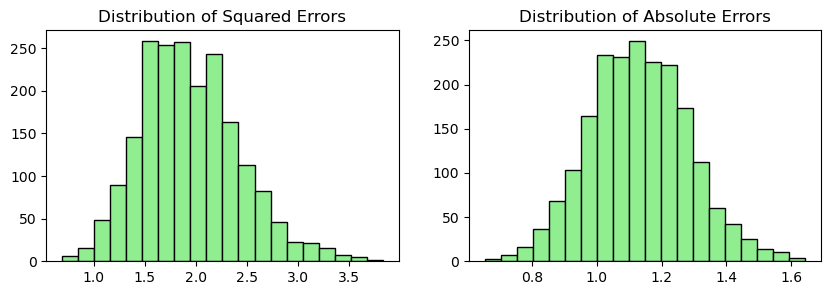

Class 1
Number of runs that contain MSE/MAE for this class: 379
MSE: average over all 379 runs: 15.0315
MSE: median over all 379 runs: 15.0239
MSE: std over all 379 runs: 2.9829
L1E: average of MAE over all 379 runs: 3.8569
L1E: median over all 379 runs: 3.8728
L1E std over all 379 runs: 0.3895

Class 2
Number of runs that contain MSE/MAE for this class: 1588
MSE: average over all 1588 runs: 7.0113
MSE: median over all 1588 runs: 6.9115
MSE: std over all 1588 runs: 2.2271
L1E: average of MAE over all 1588 runs: 2.5960
L1E: median over all 1588 runs: 2.6080
L1E std over all 1588 runs: 0.4292

Class 3
Number of runs that contain MSE/MAE for this class: 1953
MSE: average over all 1953 runs: 3.1616
MSE: median over all 1953 runs: 3.1452
MSE: std over all 1953 runs: 1.0549
L1E: average of MAE over all 1953 runs: 1.6947
L1E: median over all 1953 runs: 1.7097
L1E std over all 1953 runs: 0.3260

Class 4
Number of runs that contain MSE/MAE for this class: 1978
MSE: average over all 1978 runs: 0

In [11]:
final_test(DATA, HYPERPARAMETERS, 10, 200, device=DEVICE)